**Actividad 2:**

_Identificación de prendas de vestir con una red neuronal convolucional utilizando Fashion MNIST._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/jpimilan/RNA/blob/main/CNN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/jpimilan/RNA/blob/main/CNN_Fashion_MNIST.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

#Tabla de Contenidos

1. [Introducción](#intro)
2. [Setup](#Setup)
3. [Hiperparámetros](#hiper)
4. [Dataset](#Dataset)
5. [Preprocesamiento de datos](#pre)
6. [Modelo #1](#1-arqui)
    1. [Arquitectura](#1-arqui)
    1. [Visualización](#1-vis)
    1. [Entrenamiento](#1-train)
    1. [Resultados](#1-result)
1. [Modelo #2](#2-arqui)
    1. [Arquitectura](#2-arqui)
    1. [Visualización](#2-vis)
    1. [Entrenamiento](#2-train)
    1. [Resultados](#2-result)
1. [Modelo #3](#3-arqui)
    1. [Arquitectura](#3-arqui)
    1. [Visualización](#3-vis)
    1. [Entrenamiento](#3-train)
    1. [Resultados](#3-result)
1. [Modelo #4](#4-arqui)
1. [Modelo #5](#5-arqui)
1. [Modelo #6](#6-arqui)
1. [Modelo #7](#7-arqui)
1. [Comparación de los modelos](#comparacion)
1. [Conclusiones](#conclusiones)
1. [Referencias](#referencias)

<a id="intro"></a>
# Introduccion

Fashion-MNIST es un conjunto de datos de imágenes de artículos de moda de Zalando. Contiene 60,000 imágenes en su conjunto de entrenamiento y 10,000 imágenes en su conjunto de prueba. Cada imagen es una imagen en escala de grises de 28x28 píxeles y está asociada con una de las 10 clases.

Este proyecto tiene como objetivo comparar diferentes arquitecturas para determinar cuál tiene el mejor rendimiento en la predicción. Para comenzar, ejecute las celdas a continuación.

## Dataset in 3-D space
<img src="https://github.com/jpimilan/RNA/blob/b44ea1cd364eca0c71c00b9ad2ca1b69b3a42bc5/Image/Dataset.gif?raw=true" />

##Modelo CNN
Tres componentes básicos para definir una Convolutional Neural Network básica (en adelante CNN).
 * The Convolutional Layer
 * The Pooling layer
 * The Output layer

<img src="https://github.com/jpimilan/RNA/blob/b44ea1cd364eca0c71c00b9ad2ca1b69b3a42bc5/Image/CNN_Model.JPG?raw=true" />

###Convolutional Layer

Una capa convolucional utiliza una matriz de peso para extraer características de una imagen. Esta matriz actúa como un filtro que se desplaza por la imagen y, al multiplicarla con la parte correspondiente de la imagen y sumar los resultados, se obtiene una salida convolucionada. Este proceso permite compartir parámetros y extraer características útiles de la imagen. Al agregar más capas convolucionales, las características extraídas se vuelven más complejas y específicas.

<img src="https://github.com/jpimilan/RNA/blob/b44ea1cd364eca0c71c00b9ad2ca1b69b3a42bc5/Image/Convolutional_Layer.JPG?raw=true" />

###Pooling Layer

Las capas de agrupación (pooling) se utilizan para reducir el tamaño de las imágenes y el número de parámetros en una red. El tipo más común es el max pooling, donde se toma el valor máximo dentro de una región específica. Al aplicar la agrupación de forma independiente a cada dimensión de profundidad, la profundidad permanece igual mientras que el tamaño espacial de la imagen disminuye. Esto ayuda a retener información importante mientras se reduce la complejidad computacional.

<img src="https://github.com/jpimilan/RNA/blob/b44ea1cd364eca0c71c00b9ad2ca1b69b3a42bc5/Image/pooling.gif?raw=true" />

###Output Layer

La capa de salida es la última capa de una red neuronal convolucional (CNN). Toma la salida de las capas anteriores y genera la predicción final. Para hacer esto, se utiliza una capa completamente conectada, que asigna la entrada al número deseado de clases. La capa de salida tiene una función de pérdida, como la entropía cruzada categórica, para medir el error en la predicción. A través de la retropropagación, los pesos y sesgos de la red se actualizan para minimizar el error y mejorar la precisión de las predicciones.

<a id="Setup"></a>
# Setup

In [1]:
pip install tensorflow-datasets

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import partial
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

<a id="hiper"></a>
# Hiperparámetros

In [33]:
numero_clases = 10
numero_columnas = 28
numero_filas = 28
learning_rate = 0.001
momentum_hyper = 0.9
batch_size = 32
numero_epochs = 50
val_size = 0.2

Nota: Las variables que se mencionan como: `learning_rate`, `momentum_hyper`, `batch_size`, `numero_epochs` y `val_size` pueden considerarse hiperparámetros ya que sus valores se establecen antes del entrenamiento y pueden afectar el rendimiento del modelo. Por otro lado, las variables `numero_clases`, `numero_columnas` y `numero_filas` no son hiperparámetros ya que simplemente describen las propiedades del conjunto de datos, se han dejado acá solo por comodidad para redactar el código.

# Carga del dataset

In [34]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Visualización y despliegue de una CNN

i) Visualización

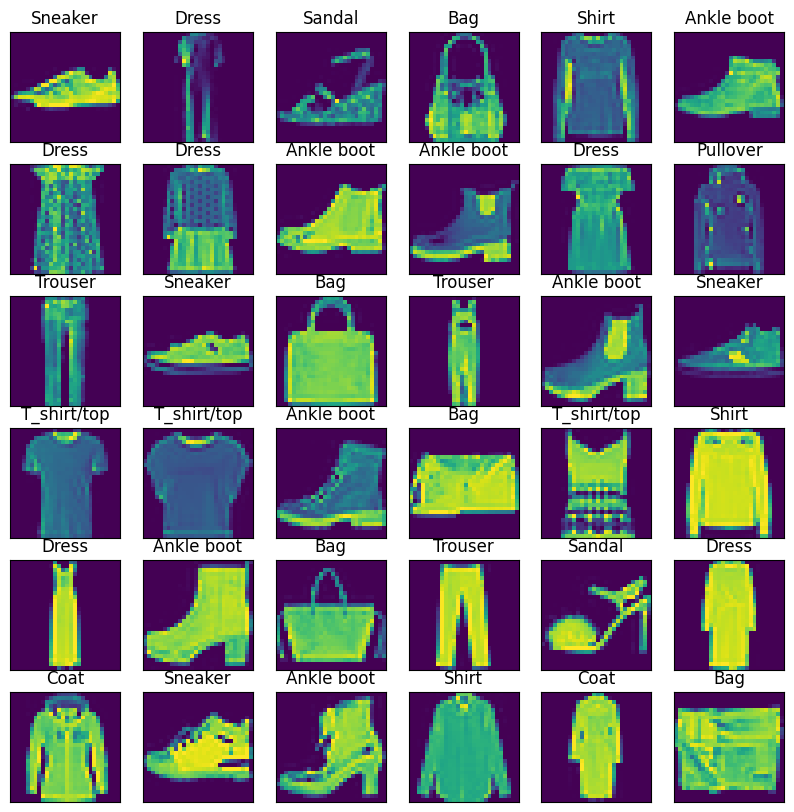

In [ ]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((28,28)))
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
plt.show()

ii) Preprocesamiento
* Ajustes de dimensionamiento y
* División de datos en conjuntos de entrenamiento, prueba y validación.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = train_labels
y_test = test_labels

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_validate = np.expand_dims(x_validate, axis=-1)

images = x_train

In [ ]:
images.shape

(48000, 28, 28, 1)

Se carga el conjunto de datos Fashion MNIST, se agrega una dimensión adicional a las imágenes (quedando: ancho, alto y la nueva dimensión canal color, en los conjuntos de entrenamiento, prueba y validación) y se cambia la escala de los valores de píxel para que estén en el rango de 0 a 1.  También asigna las etiquetas a las variables `y_train` y `y_test` y divide el conjunto de entrenamiento en conjuntos de entrenamiento y validación utilizando la función `train_test_split` del módulo `sklearn.model_selection`.

In [ ]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")

dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(32)

for batch in dataset:
    fmaps = conv_layer(batch)

In [ ]:
fmaps.shape

TensorShape([32, 28, 28, 32])

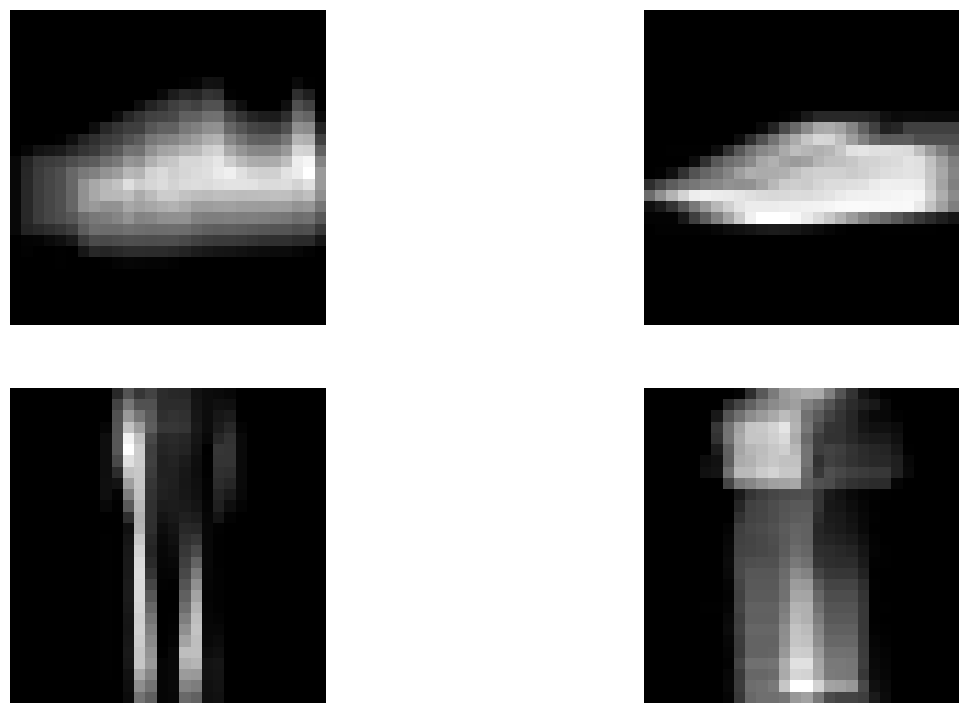

In [ ]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 1, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
biases = tf.zeros([2])
fmaps_train = tf.cast(tf.nn.conv2d(x_train, filters, strides=1, padding="SAME"), tf.float32) + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps_train[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Los filtros generados aleatoriamente suelen actuar como detectores de bordes y es una herramienta útil en el procesamiento de imágenes, y ese es el tipo de filtros con los que suele comenzar una capa convolucional. Durante el entrenamiento, el modelo aprende gradualmente, mejorando los filtros para reconocer patrones útiles.

iii) Ahora usemos cero relleno:

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(32)

fmaps_train = []

for batch in dataset:
    fmaps_batch = conv_layer(batch)
    fmaps_train.append(fmaps_batch)

fmaps_train = tf.concat(fmaps_train, axis=0)

In [ ]:
fmaps.shape

TensorShape([32, 28, 28, 32])

In [ ]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([48000, 14, 14, 32])

In [ ]:
def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

iv) Veamos los pesos:

In [ ]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 1, 32)

In [ ]:
biases.shape

(32,)

In [ ]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 1, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

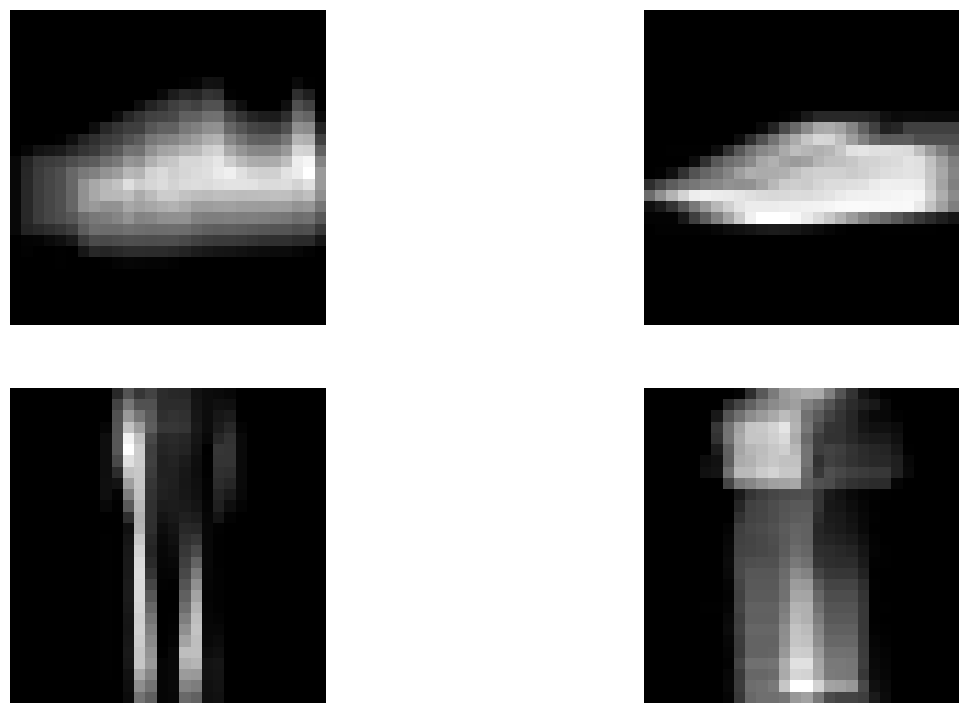

In [ ]:
images = tf.cast(images, tf.float64)
filters = tf.cast(filters, tf.float64)
biases = tf.cast(biases, tf.float64)
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 1, 2], dtype=np.float64)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Ahora se observan las líneas oscuras en la parte superior e inferior de los dos conjunto de imagenes. Esto se debe al hecho de que se utilizo cero relleno, mientras que no se utilizo cero relleno para crear los mapas de características en la figura anterior. Debido al relleno con ceros, los dos mapas de características basados ​​en el filtro de línea vertical (es decir, las dos imágenes de la izquierda) no pudieron activarse completamente cerca de la parte superior e inferior de las imágenes. De manera similar, los dos mapas de características basados ​​en el filtro de línea horizontal (es decir, las dos imágenes de la derecha) no pudieron activarse completamente cerca de la izquierda y la derecha de las imágenes.

vi) Pooling Layers
Implementación Pooling Layers con Keras

**Max pooling**

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(images)

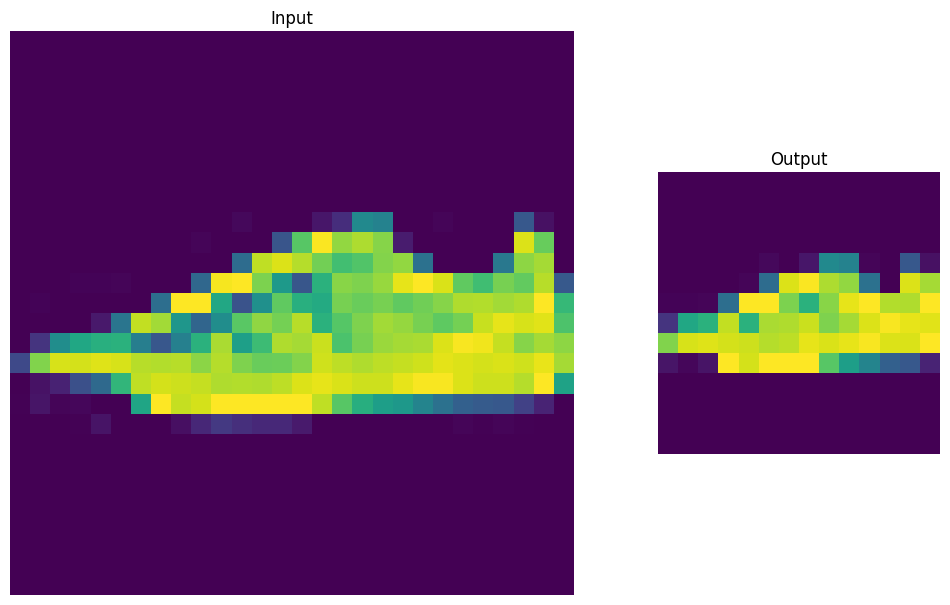

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])
ax2.axis("off")
plt.show()

**Depth-wise pooling**

In [ ]:
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [ ]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    def call(self, inputs):
        shape = tf.shape(inputs)
        if shape[-1] % self.pool_size != 0:
            raise ValueError(f"El tamaño del grupo {self.pool_size} debe ser un divisor del número de canales {shape[-1]}")
        groups = shape[-1] // self.pool_size
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [ ]:
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

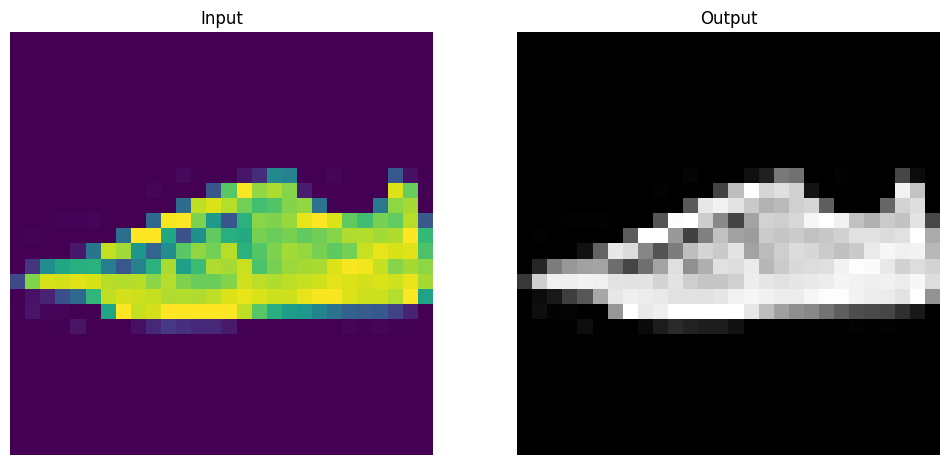

In [ ]:
depth_output = DepthPool(pool_size=1)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")
plt.axis("off")
plt.show()

**Global Average Pooling**

In [ ]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

La siguiente capa es equivalente::

In [ ]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [ ]:
global_avg_pool(images)

<tf.Tensor: shape=(48000, 1), dtype=float32, numpy=
array([[0.18465887],
       [0.06957784],
       [0.129982  ],
       ...,
       [0.22085837],
       [0.22619547],
       [0.18582433]], dtype=float32)>

<a id="#1-arqui"></a>
# Modelo 1


Implementación de una CNN con 2 capas convolucionales

a) Preprocesamiento

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [36]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11490434/11490434 [==============================] - 2s 0us/step


b) Arquitectura

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

c) Entrenamiento

In [38]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 6ms/step - loss: 0.1956 - accuracy: 0.9411 - val_loss: 0.0480 - val_accuracy: 0.9872
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0849 - accuracy: 0.9748 - val_loss: 0.0496 - val_accuracy: 0.9874


d) Resultados

In [39]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0458 - accuracy: 0.9854


[0.04576297849416733, 0.9854000210762024]

El siguiente modelo utiliza 2 capas convolucionales, seguidas de 1 capa de agrupación, luego un 25 % de abandono, luego una capa densa, otra capa de abandono pero con un 50 % de abandono y finalmente la capa de salida. Alcanza un 99,2 % de precisión en el conjunto de prueba. Esto coloca a este modelo aproximadamente en el 20 % superior en la [competencia MNIST Kaggle] (https://www.kaggle.com/c/digit-recognizer/) (si ignoramos los modelos con una precisión superior al 99,79 % que fueron probablemente entrenado en el conjunto de prueba, como lo explica Chris Deotte en [esta publicación] (https://www.kaggle.com/c/digit-recognizer/discussion/61480)). ¿Puedes hacerlo mejor? Para alcanzar una precisión del 99,5 al 99,7 % en el conjunto de prueba, debe agregar aumento de imagen, norma por lotes, usar un programa de aprendizaje como 1 ciclo y posiblemente crear un conjunto.

<a id="#2-arqui"></a>
# Modelo 2

Implementación de una CNN con Dropout

a) Preprocesamiento

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

b) Arquitectura

In [ ]:
tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

c) Entrenamiento

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 20s 9ms/step - loss: 0.7095 - accuracy: 0.7524 - val_loss: 0.3989 - val_accuracy: 0.8566
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4171 - accuracy: 0.8596 - val_loss: 0.3024 - val_accuracy: 0.8826
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3545 - accuracy: 0.8802 - val_loss: 0.3008 - val_accuracy: 0.8876
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3225 - accuracy: 0.8919 - val_loss: 0.2782 - val_accuracy: 0.9042
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2927 - accuracy: 0.8994 - val_loss: 0.2552 - val_accuracy: 0.9074
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2668 - accuracy: 0.9097 - val_loss: 0.2756 - val_accuracy: 0.9018
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2569 - accuracy: 0.9135 - val_loss: 0.2594 - val_a

d) Resultados

In [ ]:
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 94ms/step


Este código es un ejemplo de cómo construir y entrenar una red neuronal convolucional (CNN) utilizando TensorFlow. Primero, se establece una semilla aleatoria para asegurar la reproducibilidad de los resultados. Luego, se define una capa convolucional 2D predeterminada utilizando la función `partial` de Python, que toma como argumentos el tipo de capa, el tamaño del kernel, el relleno, la función de activación y el inicializador del kernel.

Después, se construye el modelo secuencial utilizando varias capas convolucionales 2D con diferentes números de filtros, seguidas por capas de agrupación máxima (MaxPool2D) para reducir la dimensionalidad de los datos. Después de las capas convolucionales, se aplana la salida y se agregan varias capas densas con funciones de activación ReLU y una capa final con 10 unidades y una función de activación softmax para la clasificación.

Finalmente, se compila el modelo especificando la función de pérdida, el optimizador y las métricas a utilizar durante el entrenamiento. Luego, se entrena el modelo utilizando los datos de entrenamiento y validación y se evalúa su rendimiento en los datos de prueba. También se muestra cómo hacer predicciones en nuevos datos utilizando el método `predict` del modelo.

<a id="#3-arqui"></a>
# Modelo 3

Implementación de una CNN ResNet-34 usando Keras

a) Preprocesamiento

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train[..., np.newaxis].astype(np.float32) / 255.0
x_test = x_test[..., np.newaxis].astype(np.float32) / 255.0

b) Arquitectura

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[28, 28, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

c) Entrenamiento

In [ ]:
model.compile(optimizer="nadam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/10
1875/1875 [==============================] - 116s 48ms/step - loss: 0.1941 - accuracy: 0.9466 - val_loss: 0.2088 - val_accuracy: 0.9389
Epoch 2/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.0791 - accuracy: 0.9772 - val_loss: 0.1516 - val_accuracy: 0.9542
Epoch 3/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.0718 - accuracy: 0.9805 - val_loss: 0.0413 - val_accuracy: 0.9874
Epoch 4/10
1875/1875 [==============================] - 93s 50ms/step - loss: 0.0611 - accuracy: 0.9830 - val_loss: 0.0747 - val_accuracy: 0.9823
Epoch 5/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.0495 - accuracy: 0.9861 - val_loss: 7.8578 - val_accuracy: 0.5022
Epoch 6/10
1875/1875 [==============================] - 91s 49ms/step - loss: 0.0432 - accuracy: 0.9881 - val_loss: 0.0330 - val_accuracy: 0.9905
Epoch 7/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.0318 - accuracy: 0.9911 - val_loss: 0.0276 

d) Resultados

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Precisión: {precision:.4f}')
print(f'Recuperación: {recall:.4f}')
print(f'Puntaje F1: {f1:.4f}')

313/313 [==============================] - 6s 15ms/step
Precisión: 0.9867
Recuperación: 0.9870
Puntaje F1: 0.9867


<a id="#4-arqui"></a>
# Modelo 4

Implementación de una CNN con Modelos preentrenados de Keras

a) Preporcesamiento

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X_train_full = np.expand_dims(X_train_full, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

b) Arquitectura

In [ ]:
model = tf.keras.applications.ResNet50(weights="imagenet")

c) Entrenamiento

In [ ]:
# Definir la arquitectura del modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compilar el modelo
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Entrenar el modelo
history = model.fit(X_train_full, y_train_full, epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 15s 5ms/step - loss: 0.4028 - accuracy: 0.8550 - val_loss: 0.3208 - val_accuracy: 0.8855
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2631 - accuracy: 0.9042 - val_loss: 0.3208 - val_accuracy: 0.8863
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2193 - accuracy: 0.9199 - val_loss: 0.2588 - val_accuracy: 0.9029
Epoch 4/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.1870 - accuracy: 0.9301 - val_loss: 0.2377 - val_accuracy: 0.9161
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1611 - accuracy: 0.9403 - val_loss: 0.2492 - val_accuracy: 0.9131
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1384 - accuracy: 0.9482 - val_loss: 0.2406 - val_accuracy: 0.9162
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1178 - accuracy: 0.9559 - val_loss: 0.2721 - val_accurac

d) Resultados

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2%}")

313/313 [==============================] - 1s 3ms/step - loss: 0.2951 - accuracy: 0.9162
Test accuracy: 91.62%


Este código carga el conjunto de datos Fashion MNIST de TensorFlow y selecciona las dos primeras imágenes del conjunto de entrenamiento. Luego, redimensiona las imágenes a un tamaño de 224x224 píxeles y las convierte a RGB. Después, utiliza un modelo pre-entrenado de ResNet50 para hacer una predicción sobre las imágenes y muestra las tres clases más probables para cada imagen. Finalmente, muestra las imágenes redimensionadas en una figura con dos subplots.

<a id="#5-arqui"></a>
# Modelo 5

Implementación de una CNN con Modelos preentrenados para el aprendizaje por transferencia

a) Preprocesamiento

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
data, info = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_data, test_data = data['train'], data['test']
dataset_size = info.splits['train'].num_examples
n_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteDLYHTE/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteDLYHTE/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full[..., np.newaxis]
X_test = X_test[..., np.newaxis]

n_valid = int(len(X_train_full) * 0.15)
n_test = int(len(X_train_full) * 0.10)
train_set_raw = (X_train_full[:-n_valid-n_test], y_train_full[:-n_valid-n_test])
valid_set_raw = (X_train_full[-n_valid-n_test:-n_test], y_train_full[-n_valid-n_test:-n_test])
test_set_raw = (X_train_full[-n_test:], y_train_full[-n_test:])

In [8]:
X_valid, y_valid = valid_set_raw

In [9]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

def preprocess_data(X, y):
    X = tf.image.grayscale_to_rgb(X)
    X = preprocess(X)
    return X, y

train_set = tf.data.Dataset.from_tensor_slices(train_set_raw).map(preprocess_data).shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = tf.data.Dataset.from_tensor_slices(valid_set_raw).map(preprocess_data).batch(batch_size)
test_set = tf.data.Dataset.from_tensor_slices(test_set_raw).map(preprocess_data).batch(batch_size)

b) Arquitectura

In [10]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

83683744/83683744 [==============================] - 5s 0us/step


c) Entrenamiento

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=2, validation_data=valid_set)

for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=1)

Epoch 1/2
1407/1407 [==============================] - 236s 158ms/step - loss: 0.4617 - accuracy: 0.8367 - val_loss: 0.3591 - val_accuracy: 0.8739
Epoch 2/2
1407/1407 [==============================] - 452s 312ms/step - loss: 0.2484 - accuracy: 0.9118 - val_loss: 0.1800 - val_accuracy: 0.9322


d) Resultados

In [12]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test accuracy: {test_acc:.2f}")
print(f"Test loss: {test_loss:.2f}")

188/188 [==============================] - 25s 131ms/step - loss: 0.1765 - accuracy: 0.9383
Test accuracy: 0.94
Test loss: 0.18


Los tres conjuntos de datos contienen imágenes individuales. Necesitamos agruparlos en lotes, pero para esto primero debemos asegurarnos de que todos tengan el mismo tamaño, de lo contrario, el agrupamiento no funcionará. Podemos usar una capa `Resizing` para esto. También debemos llamar a la función `tf.keras.applications.xception`.`preprocess_input()` para preprocesar las imágenes adecuadamente para el modelo Xception. También agregaremos barajar y precargar al conjunto de datos de entrenamiento.

Echemos un vistazo nuevamente a las primeras 9 imágenes del conjunto de validación: ahora son todas de 224x224, con valores que van de -1 a 1:

Intente ejecutar la siguiente celda varias veces para ver diferentes aumentos de datos aleatorios:

Ahora, carguemos el modelo previamente entrenado, sin sus capas superiores, y reemplácelas con las nuestras, para la tarea de clasificación de flores:

Entrenemos el modelo durante algunas épocas, mientras mantenemos fijos los pesos del modelo base:

<a id="#6-arqui"></a>
# Modelo 6

Implementación de una CNN con Xception
Arquitectura Xception pre-entrenada, Clasificación y Localización.

a) Preprocesamiento

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [19]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [20]:
n_valid = int(len(X_train_full) * 0.15)
n_test = int(len(X_train_full) * 0.10)
train_set_raw = (X_train_full[:-n_valid-n_test], y_train_full[:-n_valid-n_test])
valid_set_raw = (X_train_full[-n_valid-n_test:-n_test], y_train_full[-n_valid-n_test:-n_test])
test_set_raw = (X_train_full[-n_test:], y_train_full[-n_test:])

In [21]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224),
    tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

def preprocess_data(X, y):
    X = tf.expand_dims(X, axis=-1)
    X = preprocess(X)
    return X, y

In [22]:
batch_size = 32
train_set = tf.data.Dataset.from_tensor_slices(train_set_raw).map(preprocess_data).shuffle(1000).batch(batch_size).prefetch(1)
valid_set = tf.data.Dataset.from_tensor_slices(valid_set_raw).map(preprocess_data).batch(batch_size)
test_set = tf.data.Dataset.from_tensor_slices(test_set_raw).map(preprocess_data).batch(batch_size)

In [23]:
data, info = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_data, test_data = data['train'], data['test']
dataset_size = info.splits['train'].num_examples
n_classes = info.features['label'].num_classes
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full[..., np.newaxis]
X_test = X_test[..., np.newaxis]

n_valid = int(len(X_train_full) * 0.15)
n_test = int(len(X_train_full) * 0.10)
train_set_raw = (X_train_full[:-n_valid-n_test], y_train_full[:-n_valid-n_test])
valid_set_raw = (X_train_full[-n_valid-n_test:-n_test], y_train_full[-n_valid-n_test:-n_test])
test_set_raw = (X_train_full[-n_test:], y_train_full[-n_test:])
X_valid, y_valid = valid_set_raw
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

def preprocess_data(X, y):
    X = tf.image.grayscale_to_rgb(X)
    X = preprocess(X)
    return X, y

train_set = tf.data.Dataset.from_tensor_slices(train_set_raw).map(preprocess_data).shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = tf.data.Dataset.from_tensor_slices(valid_set_raw).map(preprocess_data).batch(batch_size)
test_set = tf.data.Dataset.from_tensor_slices(test_set_raw).map(preprocess_data).batch(batch_size)

In [24]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

b) Arquitectura

In [25]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])

c) Entrenamiento

In [26]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=["accuracy"])

model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 12s 446ms/step - loss: 1.8262 - dense_loss: 2.2245 - dense_1_loss: 0.2332 - dense_accuracy: 0.2688 - dense_1_accuracy: 0.2781
Epoch 2/2
10/10 [==============================] - 5s 446ms/step - loss: 1.3659 - dense_loss: 1.6615 - dense_1_loss: 0.1835 - dense_accuracy: 0.5094 - dense_1_accuracy: 0.3156


d) Resultados

Cómo se relaciona mAP con Precision/Recall

In [27]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

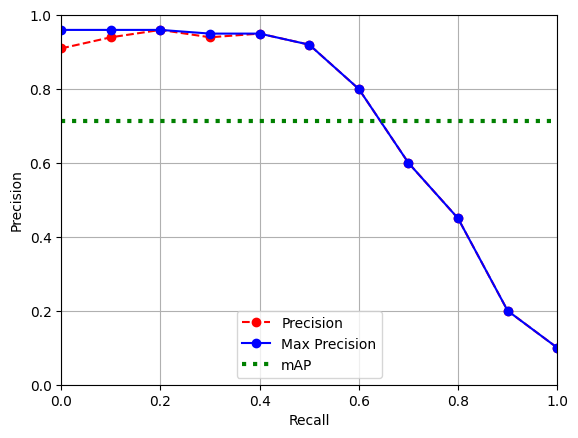

In [28]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()

Esta CNN utiliza el modelo Xception como base. El modelo Xception se carga con los pesos pre-entrenados en el conjunto de datos ImageNet y se configura para no incluir la capa superior. Luego, se agrega una capa de agrupación global promedio y dos capas densas para producir dos salidas: una para la clasificación y otra para la localización.

El código también muestra cómo se puede agregar una caja delimitadora aleatoria a las imágenes durante el preprocesamiento. Luego, el modelo se compila con dos funciones de pérdida (una para la clasificación y otra para la localización) y se entrena en un conjunto de entrenamiento falso.

Finalmente, el código muestra cómo calcular y visualizar la precisión promedio (mAP) y la precisión máxima para diferentes niveles de recuperación. La función maximum_precisions toma una lista de valores de precisión y devuelve una lista de valores de precisión máxima acumulada. Luego, se calcula el mAP como la media de los valores de precisión máxima. Finalmente, se trazan los valores de precisión, precisión máxima y mAP en una gráfica con la recuperación en el eje x y la precisión en el eje y.

# Prueba con Imagenes Nuevas

In [ ]:
import urllib.request
from PIL import Image
import numpy as np
import tensorflow as tf

image_urls = [
    'https://www.paris.cl/dw/image/v2/BCHW_PRD/on/demandware.static/-/Sites-cencosud-master-catalog/default/dwc18f58f4/images/imagenes-productos/601/405238-0001-001.jpg?sw=1480&sh=2000&sm=fit',
    'https://www.paris.cl/dw/image/v2/BCHW_PRD/on/demandware.static/-/Sites-cencosud-master-catalog/default/dw5f2d8343/images/imagenes-productos/604/483133-0340-001.jpg?sw=1480&sh=2000&sm=fit',
    'https://img.ltwebstatic.com/images3_pi/2022/07/20/1658302042fa7632a7bdec746dfcbdb140885ff22f_thumbnail_600x.jpg',
    'https://img.ltwebstatic.com/images3_pi/2022/12/05/1670204316f4be01b1c3210be8d8a326adab48a67d_thumbnail_600x.jpg',
    'https://img.ltwebstatic.com/images3_pi/2023/02/23/1677132256ff28e3aac890620fda50fa64a97acc2f_thumbnail_600x.jpg',
    'https://img.ltwebstatic.com/images3_pi/2023/01/11/1673422430eec29160b315045f67a7980f9d1e9bb8_thumbnail_600x.jpg',
    'https://img.ltwebstatic.com/images3_pi/2020/12/05/160713568464dc038bf7129c53ab7346f8970353e0.webp',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTiXy9jUjQeVo6yF8aMiccKlgxqXPiD06O_0J5UPCkr0hZAnbTMx5OxA1EuetxBG5B3wGs&usqp=CAU',
    'https://assets.adidas.com/images/h_840,f_auto,q_auto,fl_lossy,c_fill,g_auto/78b76ab3632d4251a7f2ae2b005fb600_9366/Zapatillas_adidas_Grand_Court_TD_Blanco_GW9250_01_standard.jpg',
    'https://static.theline.cl/img/products/DV0427-100-1_1024.png'
]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Crea las variables del modelo llamándolo con un lote de datos de entrada
model.build(input_shape=(None, 28, 28, 1))

# Carga los pesos del modelo previamente entrenado
model.load_weights('my_model.h5')

for url in image_urls:
    with urllib.request.urlopen(url) as f:
        image = Image.open(f).convert('L').resize((28, 28))
        image = np.array(image) / 255.0
        image = image[np.newaxis, ..., np.newaxis]
        prediction = model.predict(image)
        predicted_label = np.argmax(prediction)
        predicted_class = class_names[predicted_label]
        print(f'Predicted class for image {url}: {predicted_class}')

# Conclusiones

1. Estas son las principales ventajas de una CNN sobre una DNN totalmente conectada para la clasificación de imágenes:
    * Debido a que las capas consecutivas solo están parcialmente conectadas y debido a que reutiliza en gran medida sus pesos, una CNN tiene muchos menos parámetros que una DNN completamente conectada, lo que hace que sea mucho más rápido de entrenar, reduce el riesgo de sobreajuste y requiere muchos menos datos de entrenamiento.
    * Cuando una CNN ha aprendido un kernel que puede detectar una característica en particular, puede detectar esa característica en cualquier parte de la imagen. Por el contrario, cuando un DNN aprende una función en una ubicación, puede detectarla solo en esa ubicación en particular. Dado que las imágenes suelen tener características muy repetitivas, las CNN pueden generalizar mucho mejor que las DNN para tareas de procesamiento de imágenes como la clasificación, utilizando menos ejemplos de capacitación.
    * Finalmente, un DNN no tiene conocimiento previo de cómo se organizan los píxeles; no sabe que los píxeles cercanos están cerca. La arquitectura de una CNN incorpora este conocimiento previo. Las capas inferiores suelen identificar características en áreas pequeñas de las imágenes, mientras que las capas superiores combinan las características de nivel inferior en características más grandes. Esto funciona bien con la mayoría de las imágenes naturales, lo que le da a las CNN una ventaja decisiva en comparación con las DNN..
2. Calculemos cuántos parámetros tiene la CNN.
    * Dado que su primera capa convolucional tiene núcleos de 3 × 3 y la entrada tiene tres canales (rojo, verde y azul), cada mapa de características tiene pesos de 3 × 3 × 3, más un término de sesgo. Son 28 parámetros por mapa de funciones. Dado que esta primera capa convolucional tiene 100 mapas de características, tiene un total de 2800 parámetros. La segunda capa convolucional tiene 3 × 3 kernels y su entrada es el conjunto de 100 mapas de características de la capa anterior, por lo que cada mapa de características tiene 3 × 3 × 100 = 900 pesos, más un término de sesgo. Como tiene 200 mapas de características, esta capa tiene 901 × 200 = 180 200 parámetros. Finalmente, la tercera y última capa convolucional también tiene kernels 3 × 3, y su entrada es el conjunto de 200 mapas de características de las capas anteriores, por lo que cada mapa de características tiene 3 × 3 × 200 = 1800 pesos, más un término de sesgo. Como tiene 400 mapas de características, esta capa tiene un total de 1.801 × 400 = 720.400 parámetros. En total, la CNN tiene 2800 + 180 200 + 720 400 = 903 400 parámetros.<br/>
    * Ahora calculemos cuánta RAM requerirá esta red neuronal (al menos) al hacer una predicción para una sola instancia. Primero calculemos el tamaño del mapa de características para cada capa. Dado que estamos usando un paso de 2 y un relleno `"mismo"`, las dimensiones horizontales y verticales de los mapas de características se dividen por 2 en cada capa (redondeando hacia arriba si es necesario). Entonces, como los canales de entrada son 200 × 300 píxeles, los mapas de características de la primera capa son 100 × 150, los mapas de características de la segunda capa son 50 × 75 y los mapas de características de la tercera capa son 25 × 38. Dado que 32 bits son 4 bytes y la primera capa convolucional tiene 100 mapas de características, esta primera capa ocupa 4 × 100 × 150 × 100 = 6 millones de bytes (6 MB). La segunda capa ocupa 4 × 50 × 75 × 200 = 3 millones de bytes (3 MB). Finalmente, la tercera capa ocupa 4 × 25 × 38 × 400 = 1 520 000 bytes (alrededor de 1,5 MB). Sin embargo, una vez calculada una capa, se puede liberar la memoria que ocupaba la capa anterior, por lo que si todo está bien optimizado, solo se requerirán 6 + 3 = 9 millones de bytes (9 MB) de RAM (cuando la segunda capa haya terminado. recién computado, pero la memoria ocupada por la primera capa aún no ha sido liberada). Pero espera, ¡también necesitas agregar la memoria ocupada por los parámetros de la CNN! Calculamos anteriormente que tiene 903 400 parámetros, cada uno de los cuales usa 4 bytes, por lo que esto agrega 3 613 600 bytes (alrededor de 3,6 MB). Por lo tanto, la RAM total requerida es (al menos) 12,613,600 bytes (alrededor de 12.6 MB).<br/>
    * Por último, calculemos la cantidad mínima de RAM requerida al entrenar la CNN en un mini lote de 50 imágenes. Durante el entrenamiento, TensorFlow usa retropropagación, lo que requiere mantener todos los valores calculados durante el paso hacia adelante hasta que comience el paso hacia atrás. Entonces, debemos calcular la RAM total requerida por todas las capas para una sola instancia y multiplicarla por 50. En este punto, comencemos a contar en megabytes en lugar de bytes. Calculamos antes que las tres capas requieren respectivamente 6, 3 y 1,5 MB para cada instancia. Eso es un total de 10,5 MB por instancia, por lo que para 50 instancias, la RAM total requerida es de 525 MB. Agregue a eso la RAM requerida por las imágenes de entrada, que es 50 × 4 × 200 × 300 × 3 = 36 millones de bytes (36 MB), más la RAM requerida para los parámetros del modelo, que es de aproximadamente 3,6 MB (calculado anteriormente), más algo de RAM para los gradientes (lo descuidaremos ya que puede liberarse gradualmente a medida que la retropropagación desciende por las capas durante el paso inverso). Tenemos un total de aproximadamente 525 + 36 + 3,6 = 564,6 MB, y eso es realmente un mínimo optimista.
3. Si su GPU se queda sin memoria mientras entrena una CNN, aquí hay cinco cosas que podría intentar para resolver el problema (además de comprar una GPU con más RAM):
    * Reducir el tamaño del mini lote.
    * Reducir la dimensionalidad usando una zancada más grande en una o más capas.
    * Eliminar una o más capas.
    * Use flotantes de 16 bits en lugar de flotantes de 32 bits.
    * Distribuir la CNN a través de múltiples dispositivos.
4. Una capa de agrupación máxima no tiene ningún parámetro, mientras que una capa convolucional tiene bastantes (consulte las preguntas anteriores).
5. Una capa de normalización de respuesta local hace que las neuronas que se activan con mayor fuerza inhiban las neuronas en la misma ubicación pero en mapas de características vecinos, lo que fomenta que los diferentes mapas de características se especialicen y los separa, obligándolos a explorar una gama más amplia de características. Por lo general, se usa en las capas inferiores para tener un grupo más grande de características de bajo nivel sobre las que se pueden construir las capas superiores.
6. Las principales innovaciones de AlexNet en comparación con LeNet-5 son que es mucho más grande y profunda, y apila capas convolucionales directamente una encima de la otra, en lugar de apilar una capa de agrupación encima de cada capa convolucional. La principal innovación en GoogLeNet es la introducción de _módulos de inicio_, que permiten tener una red mucho más profunda que las arquitecturas anteriores de CNN, con menos parámetros. La principal innovación de ResNet es la introducción de conexiones salteadas, que permiten ir mucho más allá de las 100 capas. Podría decirse que su simplicidad y consistencia también son bastante innovadoras. La principal innovación de SENet fue la idea de usar un bloque SE (una red densa de dos capas) después de cada módulo inicial en una red inicial o cada unidad residual en una ResNet para recalibrar la importancia relativa de los mapas de características. La principal innovación de Xception fue el uso de capas convolucionales separables en profundidad, que analizan los patrones espaciales y los patrones en profundidad por separado. Por último, la anotación principal de EfficientNet fue el método de escalado compuesto, para escalar de manera eficiente un modelo a un presupuesto informático más grande.
7. Las redes totalmente convolucionales son redes neuronales compuestas exclusivamente por capas convolucionales y de agrupación. Los FCN pueden procesar de manera eficiente imágenes de cualquier ancho y alto (al menos por encima del tamaño mínimo). Son más útiles para la detección de objetos y la segmentación semántica porque solo necesitan mirar la imagen una vez (en lugar de tener que ejecutar una CNN varias veces en diferentes partes de la imagen). Si tiene una CNN con algunas capas densas en la parte superior, puede convertir estas capas densas en capas convolucionales para crear una FCN: simplemente reemplace la capa densa más baja con una capa convolucional con un tamaño de núcleo igual al tamaño de entrada de la capa, con un filtro por neurona en la capa densa, y usando relleno `"válido"`. En general, la zancada debe ser 1, pero puede configurarlo en un valor más alto si lo desea. La función de activación debe ser la misma que la de la capa densa. Las otras capas densas deben convertirse de la misma manera, pero usando filtros 1 × 1. De hecho, es posible convertir una CNN entrenada de esta manera remodelando adecuadamente las matrices de peso de las capas densas.
8. La principal dificultad técnica de la segmentación semántica es el hecho de que gran parte de la información espacial se pierde en una CNN a medida que la señal fluye a través de cada capa, especialmente en capas agrupadas y capas con un paso superior a 1. Esta información espacial debe ser restaurado de alguna manera para predecir con precisión la clase de cada píxel.